In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from openpyxl import Workbook
from openpyxl import load_workbook
import re
from itertools import chain
from sklearn.utils import shuffle
import nltk  
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
def load_romanian_data():
    wb = load_workbook('../articole.xlsx')
    sheet = wb['Foaie1']
    data_pos=[]
    data_neg=[]
    data_doubt=[]
    value = ''
    for i in range(1, len(sheet['B'])):
        value = str(sheet['B' + str(i)].value).replace('•', '') # remove special characters
        if bool(re.match('^(?=.*[a-zA-Z])', str(sheet['B' + str(i)].value))): # check if string not empty and has letters
            if sheet['A' + str(i)].value == 1:
                data_pos.append(value)
            elif sheet['A' + str(i)].value == 0:
                data_doubt.append(value)
            elif not sheet['A' + str(i)].value:
                data_neg.append(value)
    print("data pos len: " + str(len(data_pos)))
    print( "data neg len: " + str(len(data_neg)))
    
#     low_limit = 3000
#     high_limit = 10000
#     test_pos = data_pos[:low_limit]
#     train_pos = data_pos[low_limit:high_limit]
#     test_neg = data_neg[:low_limit]
    limit = 2400
    test_pos = data_pos[:limit]
    test_neg = data_neg[:limit]
#     train_pos = data_pos[limit:]
#     train_neg = data_neg[limit:len(data_pos)] # we make sure len of neg data = len of pos data(len neg > len pos initially)

#     train_pos = [str(w).lower() for w in train_pos]
#     train_pos = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_pos])

#     train_neg = [str(w).lower() for w in train_neg]
#     train_neg = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_neg])

    with open("data/lemma/train_pos_lemma.txt") as pos_lemma:
        train_pos_lemma = pos_lemma.readlines()
    train_pos_lemma = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_pos_lemma])
    with open("data/lemma/train_neg_lemma.txt") as neg_lemma:
        train_neg_lemma = neg_lemma.readlines()
    train_neg_lemma = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_neg_lemma])
    
    test_pos = [str(w).lower() for w in test_pos]
    test_neg = [str(w).lower() for w in test_neg]
    
    return train_pos_lemma, train_neg_lemma, test_pos, test_neg

In [3]:
def prepare_train_and_test(train_pos, train_neg, test_pos, test_neg):
    X_train = list(chain(train_pos, train_neg))
    y_train = np.concatenate((np.ones(len(train_pos), int), np.zeros(len(train_neg), int)))

    X_test = list(chain(test_pos, test_neg))
    y_test = np.concatenate((np.ones(len(test_pos), int), np.zeros(len(test_neg), int)))

    X_train_shuffled, y_train_shuffled =  shuffle(X_train, y_train)
    X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test)

    return X_train_shuffled, y_train_shuffled, X_test_shuffled, y_test_shuffled

In [4]:
def remove_stopwords(sentences_list, updated_stopwords):
    filtered_sentence = []
    for sentence in sentences_list:
        filtered_sentence.append([w for w in sentence if not w in updated_stopwords])
    return repair_sentence(filtered_sentence)


def remove_punctuation(from_train_data):
    table = str.maketrans('', '', string.punctuation)
    no_punctuation = [w.translate(table) for w in from_train_data]
    numbers = re.compile('[0-9]')
    plain_text = [numbers.sub("", word) for word in no_punctuation]
    return plain_text
    

def remove_spaces(from_train_data):
    clean_spaces_data = []
    for sentence in from_train_data:
        clean_spaces_data.append(re.sub(' +', ' ', sentence).rstrip().lstrip())
    return clean_spaces_data

def repair_sentence(sentence_list):
    return [' '.join(map(str, element)) for element in sentence_list]


def update_stopwords(stopwords):
    do_no_remove_these_sw = ['not', 'no', 'can','has','have','had','must','shan','do', 'should','was','were','won',
                             'are','cannot','does','ain', 'could', 'did', 'is', 'might', 'need', 'would']
    return [word for word in stopwords if word not in do_no_remove_these_sw]


def stem_words(from_text):
    stemmer = SnowballStemmer("romanian")
    stemmer2 = SnowballStemmer("romanian", ignore_stopwords=True)
    return [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in from_text]


def lemmatize_words(sentence):
    from pywsd.utils import lemmatize_sentence
    return lemmatize_sentence(sentence)


def sentence_tokenization(sentence):
    return word_tokenize(sentence)


def sentence_punct_tokenization(sentence):
    return WordPunctTokenizer().tokenize(sentence)


def sentence_split_tokenization(sentence):
    return ([i for i in re.split(' ', sentence) if i])


def remove_apostrophe_words(train):
    train = [w.replace("it's", 'it is')
                     .replace("that's", "that is")
                     .replace("it 's", 'it is')
                     .replace("that 's", "that is")
                     .replace("'ve", " have")
                     .replace("' ve", " have")
                     .replace("won't", "will not")
                     .replace("wo n't", "will not")
                     .replace("don't", "do not")
                     .replace("do n't", "do not")
                     .replace("can't", "can not")
                     .replace("ca n't", "can not")
                     .replace("sha n't", "shall not")
                     .replace("shan't", "shall not")
                     .replace("n't", " not")
                     .replace("'re", " are")
                     .replace("'d", " would")
                     .replace("'ll", " will") for w in train]
    return train

def remove_empty_sentences(X, y):
    new_X = []
    new_y = []
    for i in range(len(X)):
        if len(X[i].split()) > 1:
            new_X.append(X[i])
            new_y.append(y[i])
    return new_X, new_y

In [5]:
def feature(X_train):
    stopwords = set(nltk.corpus.stopwords.words('romanian'))
    
    tokenized_sentence = []
    for sentence in X_train:
        tokenized_sentence.append(sentence_punct_tokenization(sentence))

    # NO STOP WORDS
    train_without_stopwords = remove_stopwords(tokenized_sentence, stopwords)

    # NO PUNCTUATION
    train_without_punctuation = remove_punctuation(train_without_stopwords)
    train_clean_spaces = remove_spaces(train_without_punctuation)
    return train_clean_spaces # we choose to extract stop words

# Main

In [6]:
train_pos, train_neg, test_pos, test_neg = load_romanian_data()

data pos len: 11077
data neg len: 23509


In [7]:
X_train, y_train, X_test, y_test = prepare_train_and_test(train_pos, train_neg, test_pos, test_neg)

In [8]:
feat_train = feature(X_train)

In [9]:
PRESETS_DICTIONARY = {'PAN18_English': {'dataset_name': 'PAN 2018 English',
                                            'word_ngram_range': (1, 3),
                                            'perform_dimentionality_reduction': True,
                                            },
                          'PAN18_Spanish': {'dataset_name': 'PAN 2018 Spanish',
                                            'word_ngram_range': (1, 2),
                                            'perform_dimentionality_reduction': False,
                                            },
                          'PAN18_Arabic': {'dataset_name': 'PAN 2018 Arabic',
                                            'word_ngram_range': (1, 2),
                                            'perform_dimentionality_reduction': False,
                                            },
                          }
PRESET = PRESETS_DICTIONARY["PAN18_English"]


word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=PRESET['word_ngram_range'],
                                  min_df=2, use_idf=True, sublinear_tf=True)
# Build a vectorizer that splits strings into sequences of 3 to 5 characters
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5),
                                 min_df=2, use_idf=True, sublinear_tf=True)
# %% Trying out count vectorizer
# vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word', min_df=1)

# Build a transformer (vectorizer) pipeline using the previous analyzers
# *FeatureUnion* concatenates results of multiple transformer objects
ngrams_vectorizer = Pipeline([('feats', FeatureUnion([('word_ngram', word_vectorizer),
                                                     ('char_ngram', char_vectorizer),
                                                     ])),
                             # ('clff', LinearSVC(random_state=42))
                             ])

# Fit (learn vocabulary and IDF) and transform (transform documents to the TF-IDF matrix) the training set
X_train_ngrams_tfidf = ngrams_vectorizer.fit_transform(X_train)

In [10]:
feature_names_ngrams = [word_vectorizer.vocabulary_, char_vectorizer.vocabulary_]
feature_names_ngrams

[{'dacă': 19776,
  'avea': 5614,
  'dub': 27565,
  'el': 28153,
  'pune': 54410,
  'pe': 49334,
  'cetăţean': 13333,
  'să': 62612,
  'mai': 41546,
  'mânca': 45139,
  'încă': 74924,
  'un': 67206,
  'ceafă': 12927,
  'dacă avea': 19789,
  'avea dub': 6428,
  'el pune': 28896,
  'pune pe': 54473,
  'pe cetăţean': 49522,
  'cetăţean să': 13353,
  'să mai': 63426,
  'mai mânca': 42079,
  'încă un': 74963,
  'un ceafă': 67567,
  'el pune pe': 28898,
  'pe cetăţean să': 49523,
  'să mai mânca': 63441,
  'poziție': 52632,
  'absolut': 655,
  'incomod': 36940,
  'în': 72784,
  'care': 11400,
  'nimeni': 46124,
  'nu': 46560,
  'trebui': 65920,
  'sta': 61357,
  'sine': 59009,
  'plânge': 51896,
  'corporatist': 15479,
  'din': 25609,
  'piperă': 51542,
  'în care': 73073,
  'care nimeni': 11828,
  'nimeni nu': 46139,
  'nu avea': 46593,
  'avea trebui': 7970,
  'trebui să': 65950,
  'să sta': 63922,
  'sine plânge': 59679,
  'plânge un': 51928,
  'un corporatist': 67714,
  'corporatist din':

In [11]:
X_test_ngrams_tfidf = ngrams_vectorizer.transform(X_test)

In [74]:
svd = TruncatedSVD(n_components=80, random_state=13)
# Fit the LSI model and perform dimensionality reduction
X_train_ngrams_tfidf_reduced = svd.fit_transform(X_train_ngrams_tfidf)
X_test_ngrams_tfidf_reduced = svd.transform(X_test_ngrams_tfidf)

In [13]:
# 4. Linear Support Vector Machine
svm_clf = LinearSVC(loss = 'hinge', penalty = 'l2', tol = 1e-4, max_iter = 1000)
svm_clf.fit(X_train_ngrams_tfidf_reduced, y_train)
predicted_test = svm_clf.predict(X_test_ngrams_tfidf_reduced)
predicted_train = svm_clf.predict(X_train_ngrams_tfidf_reduced)
print('========== 4. Support Vector Machine with Linear Kernel ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== 4. Support Vector Machine with Linear Kernel ==========
The F-1 score for test query is 0.6668761785040855
Training accuracy of SVM model is 0.6317109312663856
Test accuracy of SVM model is 0.66875



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [14]:
# 3. Random Forest.
rf_clf = RandomForestClassifier(n_estimators = 200, max_depth = 100)
rf_clf.fit(X_train_ngrams_tfidf_reduced, y_train)
predicted_test = rf_clf.predict(X_test_ngrams_tfidf_reduced)
predicted_train = rf_clf.predict(X_train_ngrams_tfidf_reduced)
print('========== 3. Random Forest ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of random forest model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of random forest model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== 3. Random Forest ==========
The F-1 score for test query is 0.6608333333333334
Training accuracy of random forest model is 0.999601048672062
Test accuracy of random forest model is 0.6608333333333334



In [15]:
from sklearn.feature_selection import mutual_info_classif
res = dict(zip(word_vectorizer.get_feature_names(),
               mutual_info_classif(X_train_ngrams_tfidf_reduced, y_train, discrete_features=True)
               ))

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train_ngrams_tfidf_chi = SelectKBest(chi2, k=300).fit_transform(X_train_ngrams_tfidf, y_train)
X_test_ngrams_tfidf_chi = SelectKBest(chi2, k=300).fit_transform(X_test_ngrams_tfidf, y_test)
X_train_ngrams_tfidf_chi.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03150005, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0196568 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01800177, 0.        ,
        0.        ]])

In [17]:
# 3. Random Forest.
rf_clf = RandomForestClassifier(n_estimators = 300, max_depth = 100)
rf_clf.fit(X_train_ngrams_tfidf_chi, y_train)
predicted_test = rf_clf.predict(X_test_ngrams_tfidf_chi)
predicted_train = rf_clf.predict(X_train_ngrams_tfidf_chi)
print('========== 3. Random Forest ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of random forest model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of random forest model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== 3. Random Forest ==========
The F-1 score for test query is 0.4593773701222893
Training accuracy of random forest model is 0.9989171321098826
Test accuracy of random forest model is 0.5239583333333333



In [18]:
# 4. Linear Support Vector Machine
svm_clf = LinearSVC(loss = 'hinge', penalty = 'l2', tol = 1e-4, max_iter = 1000)
svm_clf.fit(X_train_ngrams_tfidf_chi, y_train)
predicted_test = svm_clf.predict(X_test_ngrams_tfidf_chi)
predicted_train = svm_clf.predict(X_train_ngrams_tfidf_chi)
print('========== 4. Support Vector Machine with Linear Kernel ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== 4. Support Vector Machine with Linear Kernel ==========
The F-1 score for test query is 0.4606876262793467
Training accuracy of SVM model is 0.6799840419468824
Test accuracy of SVM model is 0.5322916666666667



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [19]:
print("number of data(tfidf): " + str(X_train_ngrams_tfidf.shape[0]))
print("data dimension(tfidf): " + str(X_train_ngrams_tfidf.shape[1]))

print("number of data(tfidf + pca): " + str(X_train_ngrams_tfidf_reduced.shape[0]))
print("data dimension(tfidf + pca): " + str(X_train_ngrams_tfidf_reduced.shape[1]))

number of data(tfidf): 17546
data dimension(tfidf): 202397
number of data(tfidf + pca): 17546
data dimension(tfidf + pca): 6


# Ensemble methods

# Bagging

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import plot_learning_curves

In [21]:
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)    

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Accuracy: 0.59 (+/- 0.01) [Decision Tree]


ValueError: X must be a NumPy array. Found <class 'scipy.sparse.csr.csr_matrix'>

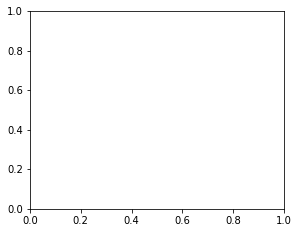

In [98]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X_train_ngrams_tfidf, y_train, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    value = 1.5
    width = 0.75
    
    clf.fit(X_train_ngrams_tfidf, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_ngrams_tfidf, y=y_train, clf=clf, feature_index=[0,2],
#                         filler_feature_values={2: value, 3: value, 4: value, 5: value},
#                         filler_feature_ranges={2: width, 3: width, 4: width, 5: width},
                        legend=2)
    plt.title(label)

plt.show()

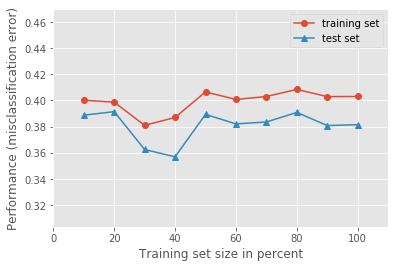

In [99]:
#plot learning curves
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train_ngrams_tfidf, y_train, X_test_ngrams_tfidf, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

In [100]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X_train_ngrams_tfidf, y_train, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

KeyboardInterrupt: 

In [ ]:
plt.figure()
num_est = np.linspace(1,100,20).astype(int)
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

# Boosting

In [50]:
from sklearn.ensemble import AdaBoostClassifier

In [59]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

Accuracy: 0.60 (+/- 0.01) [AdaBoost (n_est=1)]
Accuracy: 0.60 (+/- 0.01) [AdaBoost (n_est=2)]
Accuracy: 0.60 (+/- 0.01) [AdaBoost (n_est=3)]
Accuracy: 0.60 (+/- 0.01) [AdaBoost (n_est=10)]


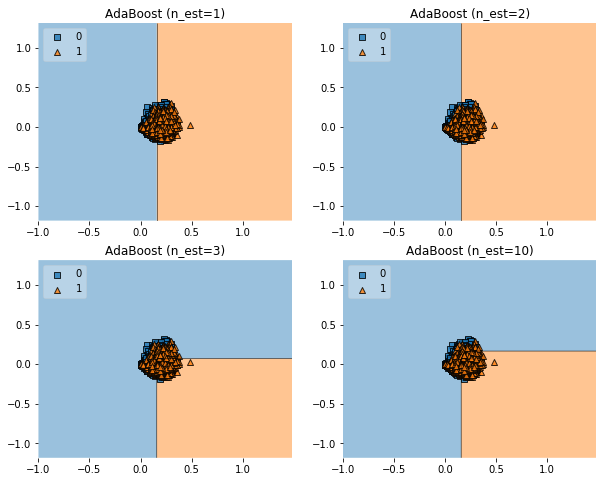

In [60]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):
    scores = cross_val_score(clf, X_train_ngrams_tfidf_reduced, y_train, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X_train_ngrams_tfidf_reduced, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_ngrams_tfidf_reduced, y=y_train, clf=boosting, legend=2)
    plt.title(label)

plt.show()

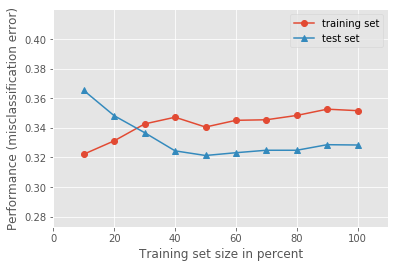

In [106]:
boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(X_train_ngrams_tfidf, y_train, X_test_ngrams_tfidf, y_test, boosting, print_model=False, style='ggplot')
plt.show()

In [107]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X_train_ngrams_tfidf, y_train, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

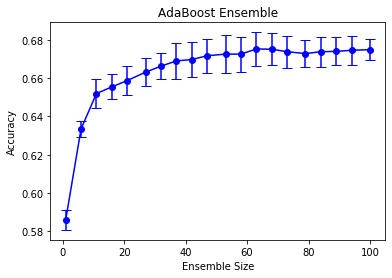

In [108]:
plt.figure()
num_est = np.linspace(1,100,20).astype(int)
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

In [88]:
from sklearn import datasets

iris = datasets.load_iris()
X_iris, y_iris = iris.data[:, 1:3], iris.target



202397

In [105]:
print(type(X_train_ngrams_tfidf_reduced))
print(X_train_ngrams_tfidf_red.shape[1])

<class 'numpy.ndarray'>
80
